# **Chap7：Bagging和随机森林**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from copy import deepcopy
from tqdm import tqdm
import seaborn as sns
colors = sns.palettes.color_palette("muted")

接下来的部分，我们将介绍**集成模型**（**ensemble**），主要包含两类：**Bagging**和**Boosting**

简单来说，集成模型通过组合多个**基学习器**（**base estimator**）构成最终的模型，**单个基学习器处理目标问题的能力可能有限、或者不稳定**，但组合多个基学习器就能取得非常好的效果，而**Bagging和Boosting就是两类组合基学习器的方法**

本章主要介绍**Bagging**方法的思想，及基于决策树的Bagging模型**随机森林**

## **1 Bootstrap和Bagging**

### **1.1 Bootstrap**

Bootstrap来自于**Pull up by your own bootstrap**，即通过拉靴子把自己提起来，后面寓意发生改变，现在通常隐喻**不需要外界帮助，仅依靠自身力量让自己变得更好**，因此Bootstrap又称为**自助法**

Bootstrap通**过对样本有放回抽样**的方法来构造统计模型，是统计学中常用的**非参数统计方法**，统计学中常**用Bootstrap评估统计准确性**

我们用下面的一个简单例子，来说明Bootstrap的作用. 假设随机变量 $X\sim N(\mu,1)$，这里假设 $\mu=0$，假设 $x_i,i=1,\cdots,N$ 是来自于总体 $X$ 的独立样本

$$
x_i\sim N(0,1),\quad i=1,\cdots,N
$$

我们取 $N = 50$ 来生成一组样本

In [2]:
# 生成 50 个 N(0,1) 的独立同分布样本
X = np.random.normal(0,1,50)

接下来，考虑用这组样本来**估计总体均值** $\mu$，最常用的**无偏估计是样本均值** $\overline{X}$：

$$
\hat{\mu} = \overline{X} = \frac{1}{N}\sum_{i=1}^{N}x_i
$$

In [3]:
# 使用样本均值估计总体均值
print("估计得到的总体均值为：%.4f"%(X.mean()))

估计得到的总体均值为：0.0756


Bootstrap方法在处理该问题时，假设**样本即是伪总体**，然后重复 $B$ 次从该伪总体中抽取容量为 $N$ 的样本 $\{x_i^{(b)}\}_{i=1}^{N},b=1,\cdots,B$，得到 $B$ 个样本均值 $\overline{X}^{(b)}$，在取这 $B$ 个样本均值的聚合得到估计量：

$$
\hat{\mu} = \frac{1}{B}\sum_{b=1}^{B} \overline{x}^{(b)}
$$

首先，我们可以绘制和构造**经验累积分布函数** $\Psi(x)$

Text(0.5, 1.0, 'Empirical Cumulative Distribution Function')

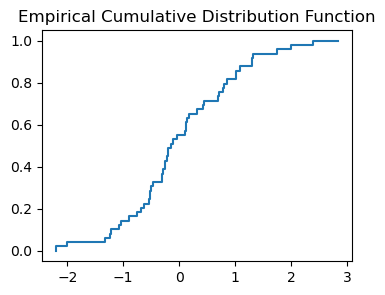

In [4]:
X = np.sort(X)
y = np.linspace(0,1,len(X))
fig = plt.figure(figsize=(4,3))
plt.step(X,y)
plt.title("Empirical Cumulative Distribution Function")

取上述函数的**反函数** $\Psi^{-1}(x)$，就可以用于构造伪总体了，每次生成样本时，只需要取 $N$ 个独立同分布的均匀分布 $U[0,1]$ 随机数 $x_i$，$\Psi^{-1}(x_i)$ 即为所求

Text(0.5, 1.0, 'Inverse Empirical Cumulative Distribution Function')

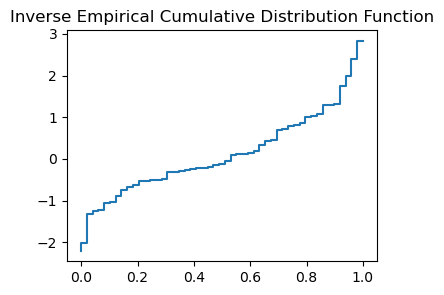

In [5]:
# 绘制反函数
fig = plt.figure(figsize=(4,3))
plt.step(y,X)
plt.title("Inverse Empirical Cumulative Distribution Function")

In [6]:
def inv_Psi(r, X):
    """
    Parameters
    ----------
    r : np.ndarray
        均匀分布 U[0,1] 的随机数
    X : np.ndarray
        生成伪总体的样本
    """
    # 排序
    X = sorted(X)
    index = np.int_(r*len(X))
    samples = [X[i] for i in index]
    return np.array(samples)

我们取 $B = 200$，来构造我们的Bootstrap估计结果

In [7]:
B = 300
mu = []
for b in range(B):
    R = np.random.rand(50)
    samples = inv_Psi(R,X)
    mu.append(samples.mean())
mu_hat = np.mean(mu)
print("Bootstrap估计得到的总体均值为：%.4f"%(mu_hat))

Bootstrap估计得到的总体均值为：0.0737


Bootstrap还可以帮助我们绘制**均值估计量的分布**

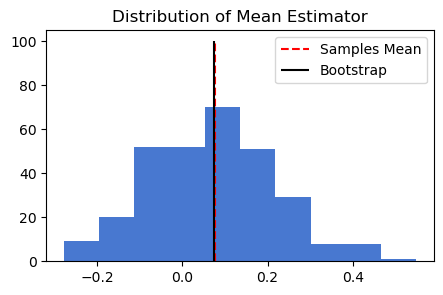

In [8]:
fig = plt.figure(figsize=(5,3))
plt.hist(mu,bins=10,color=colors[0])
plt.title("Distribution of Mean Estimator")
plt.vlines(X.mean(),0,100,color="red",ls="--",label="Samples Mean")
plt.vlines(mu_hat,0,100,color="black",label="Bootstrap")
plt.legend()

上面的直方图可以简单理解为：
* 从**总体中多次抽样**，**样本均值的估计量存在随机性**，其分布如上图所示
* Bootstrap通过多次抽样聚合的方法，**降低估计量的方差**，使其总处于**估计量分布的中心**

我们可以从数学上简单理解上述事实，设有样本 $Z=(z_1,\cdots,z_n)$，其中 $z_i = (x_i,y_i)$ 表示样本对，$x_i$ 是特征，$y_i$ 是标签，我们感兴趣的估计量是 $S(Z)$，我们基于Bootstrap方法估计 $S(Z)$ 的分布，进而得到相应的参数的估计，例如考虑方差：

$$
\hat{\text{Var}}\left[ S(Z) \right] = \frac{1}{B-1} \sum_{b}^{B}\left( S(Z^{(b)}) - \overline{S}^* \right)
$$

其中，$Z^{(b)},b=1,\cdots,B$ 是第 $b$ 次Bootstrap抽样样本集合，$\overline{S}^*$ 是聚合估计量：

$$
\overline{S}^* = \frac{1}{B}\sum_{b=1}^{B} S(Z^{(b)})
$$

本质上，$\hat{\text{Var}}\left[ S(Z)\right]$ 可以当作 $S(Z)$ 方差的**蒙特卡洛估计**

对于一个统计学习问题，回顾模型的**偏差方差分解**，模型 $f$ 的估计误差 $\text{err}$ 可以分解为：

$$
\text{err}(x) = bias^2(x) + var(x) + \varepsilon^2
$$

回顾各项的含义：

**(1) 偏差项 $bias^2(x)$**  
偏差部分 $bias^2(x)$ 是**模型期望预测与真实标签**之间的差距，通过它能判断：
* $bias^2(x)$ 刻画**模型自身的拟合能力**
* $bias^2(x)$ 刻画**模型的预测是否出现系统性偏差**

**(2) 方差项 $var(x)$**  
方差部分 $var(x)$ 度量了**训练集变动对模型学习性能的影响**，通过它能判断：
* **模型面对数据扰动的应对能力**，或着说**对不同分布的掌握能力**
* **数据分布变化给模型预测带来的影响**

**(3) 噪声项 $\varepsilon^2$**  
噪声部分 $\varepsilon^2$ 度量了**模型在该机器学习任务下预测误差能达到的下界**，它表明了：
* 这是**观测标签和真实标签之间的系统性偏差**，**不是模型能够解决的**
* $\varepsilon^2$ 刻画了该**机器学习问题的难度**

因此，**Bootstrap方法的引入使得机器学习模型的表现提升，核心是降低了模型的方差** $var(x)$

### **1.2 Bagging**

#### **1.2.1 Bagging方法思想**

下面，我们正式将**Bootstrap**引入机器学习模型，得到**Bagging**方法，它是**Bootstrap Aggregation**的简称

**Bagging**方法的大致流程如下：
* 从训练样本集中**有放回**的选出样本，对这些样本建立机器学习模型 $E_b$（例如逻辑回归、SVM、决策树等）
* 重复上述步骤 $B$ 次，得到 $B$ 个估计器 $E_b,b=1,\cdots,B$
* 在预测时，通过聚合方法完成预测：
    * 如果是回归问题，则取 $B$ 个估计器预测的**均值**
    * 如果是分类问题，则取 $B$ 个估计器预测的**众数**

将其写作标准算法流程如下

**(Algo) Bagging**  
* **输入**：数据集 $D=\{(x_i,y_i)\}_{i=1}^{N}$，学习算法 $E$，Bootstrap轮数 $B$
* **输出**：Bagging聚合学习器 $f(x)
* **算法流程**：
```python
for b in range(B):
    D_bs = bootstrap_samples(D) # Bootstrap抽样
    E_b = E(D_bs) # 训练第 b 个学习器
```
在估计时，分为回归问题和分类问题：
* 回归问题取均值：
$$
f(x) = \frac{1}{B} E_b(x)
$$
* 分类问题用投票：
$$
f(x) = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} \sum_{b=1}^{B} \mathbb{I}(E_b(x) = y)
$$

#### **1.2.2 Bagging方法优点**

**(1) 计算复杂度低且可并行**

我们来考虑Bagging方法的**计算复杂度**，假定训练每个基学习器的计算复杂度为 $\mathcal{O}(m)$，最后聚合平均的计算复杂度为 $\mathcal{O}(s)$，则总复杂度为：
$$
B\cdot\mathcal{O}(m) + \mathcal{O}(s)
$$

模型的推理时间 $\mathcal{O}(s)$ 相比训练时间而言是一个很小的常数，因此**计算复杂度主要在训练部分**

一般而言，$B$ 相比 $\mathcal{O}(m)$ 而言是一个固定常数，例如 $B = 50$，我们可以认为**Bagging方法的计算复杂度与基学习器同阶**

即使同阶，**Bagging**的训练市场依然会消耗基学习器训练时间的 $B$ 倍，这在 $\mathcal{O}(m)$ 很大或者 $B$ 很大时显得有些无法接受

但好处在于，**Bagging**方法**各个学习器之间是独立存在**的，从Bootstrap的采样到它们的训练都可以**并行处理**，随着现在处理器核心数量的不断增加，借助多核心优势，我们能快速并行训练Bagging模型，大大缩短训练所需要的时间

**(2) 降低模型方差**

我们正式从**偏差方差分解**的角度来分析Bagging模型

假设真实数据服从分布 $y=f(x)+\varepsilon,\varepsilon\sim N(0,\sigma^2)$，通过某种学习算法，基于训练样本 $T$ 得到了预测模型 $\hat{f}(x;T)$，对于测试集中的样本 $(x_0,y_0)$，期望预测误差分解为：

$$
\mathbb{E}\left( \hat{f}(x_0;T) - y_0 \right)^2 = bias^2(x_0) + var(x_0) + \sigma^2
$$

其中：
* 偏差：$bias(x_0) = \mathbb{E}_T\left[ \hat{f}(x_0;T) \right] - f(x_0)$
* 方差：$var(x_0) = \mathbb{E}_T\left( \hat{f}(x_0;T) - \mathbb{E}_T\left[ \hat{f}(x_0;T) \right] \right)^2$

假设我们可以从训练样本中**无限次抽样**，则最优的预测函数应该是：

$$
f_{\text{bag}}^*(x) = \mathbb{E}_T[\hat{f}(x;T)]
$$

此时，根据偏差方差分解，对于样本 $(x_0,y_0)$，期望预测误差为：

$$
\mathbb{E}\left(y_0 - f_{\text{bag}}^*(x_0)\right)^2 = \left( \mathbb{E}_T[\hat{f}(x_0;T)] - f(x_0)\right)^2 + \sigma^2 \leq \mathbb{E}\left( y_0 - \hat{f}(x_0;T) \right)^2
$$

上式说明，**理想的Bagging估计器是偏差方差分解的下界**

但无限次抽样在实际操作中不可行，我们退一步考虑真实的Bagging估计器：

$$
\overline{f}_{\text{bag}}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f} (x;T^{(b)})
$$

再次代入偏差方差分解，会得到：

$$
\mathbb{E}\left( y_0 - \overline{F}_{\text{bag}}(X_0) \right)^2 = \left( \mathbb{E}_T[\hat{f}(x_0;T)] - f(x_0)\right)^2 + \frac{var(x_0)}{B} + \sigma^2 \leq \mathbb{E}\left( y_0 - \hat{f}(x_0;T) \right)^2
$$

上述结果表明，**如果我们能从总体中独立同分布的抽取训练样本** $T^{(b)}$，**则可以通过降低方差** $var(x_0)$ **来降低预测误差**

实际使用时，**总体是未知的，因此Bagging采用的是Bootstrap方案**

**(3) 可以进行包外估计**

包外估计的思想类似于**交叉验证**，由于Bootstrap阶段，每个基学习器所使用的样本 $T^{(b)}$ 没有包含所有的样本 $x\in T$，因此，对于基学习器 $E_b$ 而言，那些它未使用的样本就可以用来估计模型的泛化性能

假设基学习器 $E_b$ 的采样**只从原始训练集采样** $2/3$ 的样本，则余下的 $1/3$ 的样本就可以作为**验证集**使用，因此**包外估计能够作为Bagging算法提供估计模型泛化误差的方法**

设 $T^{(b)}$ 是模型 $E_b$ 实际使用的训练数据，$H^{oob}(x)$ 表示对样本 $x$ 的包外预测，即仅考虑**那些未使用** $x$ **进行训练的基学习器**在 $x$ 上的表现，有：

* 对于分类问题：
$$
H^{oob}(x) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} \sum_{b=1}^{B} \mathbb{I}(E_b(x) = y)\cdot \mathbb{I}(x\notin T^{(b)})
$$
* 对于回归问题：
$$
H^{oob}(x) = \frac{1}{\sum_{b=1}^{B} \mathbb{I}(x\notin T^{(b)})} \sum_{b=1}^{B} E_b(x)\cdot \mathbb{I}(x\notin T^{(b)})
$$

获得包外估计 $H^{oob}(x)$ 后，就可以让他与训练集标签 $y$ 对比，计算相应的评估指标，例如正确率、均方误差等

#### **1.2.3 Bagging实验**

首先，我们生成一个简单的二分类数据集

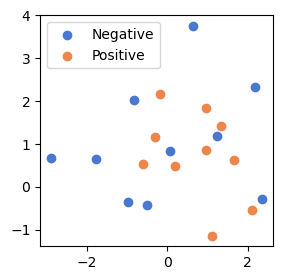

In [9]:
# 创建数据集
X,y = make_moons(n_samples=20,noise=1,random_state=1234)
fig = plt.figure(figsize=(3,3))
plt.scatter(X[y==0,0],X[y==0,1],color=colors[0],label="Negative")
plt.scatter(X[y==1,0],X[y==1,1],color=colors[1],label="Positive")
plt.legend()

我们定义一个Bootstrap函数`bootstrap_samples()`用来生成Bagging基学习器的样本

In [10]:
def bootstrap_samples(X : np.ndarray, y : np.ndarray):
    # 样本量
    N = X.shape[0]
    # 随机采样
    resample_index = np.random.choice(range(N),N)
    resample_X = X[resample_index]
    resample_y = y[resample_index]
    return resample_X, resample_y

我们再定义一个函数`plot_decision_boundary()`，用于**可视化决策边界**

In [11]:
def plot_decision_boundary(data, labels, clf):
    """
    绘制决策边界
    
    Parameters
    ----------
    data : np.ndarray
        特征数据
    labels : np.ndarray
        数据集标签
    clf : Any
        训练后的分类器
    """
    plot_step = 0.02
    x_min, x_max = data[:,0].min() -1, data[:,0].max() + 1
    y_min,y_max = data[:,1].min() -1 , data[:,1].max() + 1
    # 绘制决策边界
    xx,yy = np.meshgrid(np.arange(x_min,x_max,plot_step),
                        np.arange(y_min,y_max,plot_step))
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(3,3))
    cs = plt.contourf(xx,yy,Z,cmap=sns.cm.icefire,alpha=0.5)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')

    plt.scatter(data[labels==0,0],data[labels==0,1],color=colors[0],label="Negative")
    plt.scatter(data[labels==1,0],data[labels==1,1],color=colors[1],label="Positive")
    plt.legend()

首先，我们以决策树为基学习器，生成Bootstrap样本，训练模型，绘制决策边界

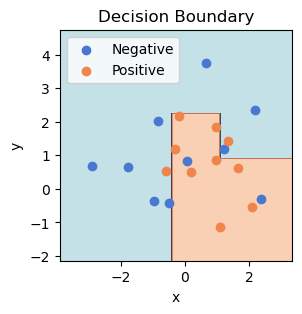

In [12]:
# 生成 Bootstrap 样本
X_bs, y_bs = bootstrap_samples(X,y)
# 创建模型并训练
tree = DecisionTreeClassifier()
tree.fit(X_bs,y_bs)
plot_decision_boundary(X,y,tree)

图中观察到**仅使用一组Bootstrap样本，模型预测存在很多误分类样本**，下面，我们尝试使用Bagging学习器，相关参数可以查看文档，这里主要说明两个：
* `n_estimators`，整数，控制基学习器的数量 $B$
* `n_jobs`，整数，控制Bagging基学习器训练的并行进程数量，最大不超过当前计算机CPU的核心数，**设置为**`-1`**表示使用所有核心并行**

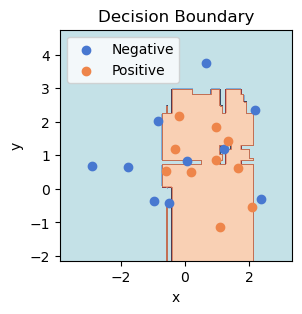

In [13]:
# 创建Bagging学习器
bag_tree = BaggingClassifier(tree,n_estimators=50,n_jobs=-1)
# 直接提供原训练数据，BaggingClassifier会自动Bootstrap采样
bag_tree.fit(X,y)
plot_decision_boundary(X,y,bag_tree)

效果立竿见影，Bagging学习器完成了几乎所有样本的正确分类

由于Bagging方法非常简单，我们也可以自己编写Bagging模型`MyBaggingClassifier`

In [14]:
class MyBaggingClassifier:
    def __init__(self, estimator, B : int):
        """
        Parameters
        ----------
        estimator : Any
            基学习器算法
        B : int
            基学习器个数
        """
        self.estimator = estimator
        self.B = B
        self.base_estimators = []
    
    def fit(self, X : np.ndarray, y : np.ndarray):
        """
        训练Bagging模型
        """
        for b in range(self.B):
            # 生成 Bootstrap 样本
            X_bs, y_bs = bootstrap_samples(X,y)
            # 拷贝模型，进行训练
            model = deepcopy(self.estimator)
            model.fit(X_bs,y_bs)
            # 添加到基学习器列表
            self.base_estimators.append(model)
    
    def predict(self, X : np.ndarray):
        """
        进行预测
        """
        # 首先每个基学习器进行预测
        x_preds = []
        for model in self.base_estimators:
            x_preds.append(model.predict(X))
        x_preds = np.array(x_preds)
        
        # 用众数投票汇总
        preds = []
        for i in range(X.shape[0]):
            preds.append(Counter(x_preds[:,i]).most_common()[0][0])
        return np.array(preds)

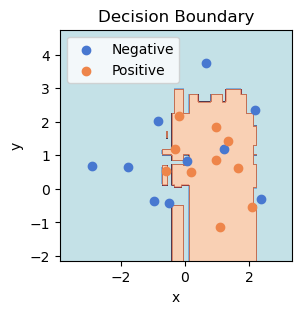

In [15]:
# 创建Bagging学习器
my_bag_tree = MyBaggingClassifier(tree,B=20)
# 直接提供原训练数据，BaggingClassifier会自动Bootstrap采样
my_bag_tree.fit(X,y)
plot_decision_boundary(X,y,my_bag_tree)

----

## **2 随机森林**

### **2.1随机森林模型**

**随机森林**（**Random Forest**，简称**RF**）是基于决策树的Bagging模型，由于基学习器是决策树，自然地人们形象地将Bagging决策树称为随机森林

随机森林在Bagging模型基础上，还根据决策树的特点，额外增加了一些特性，进一步**降低模型方差**

随机森林的随机体现在两个方面：
* **采样随机性**
* **特征选择的随机性**

随机森林算法的大致流程如下，基学习器使用CART决策树：
* 假设有 $N$ 个样本，对第 $b$ 棵树，从样本中抽取 $N$ 个样本
* 假设每个样本有 $p$ 个特征，在决策树的每个结点处：
    * 随即从这 $p$ 个特征中选择出 $q$ 个，满足 $q < p$
    * 利用随机选择出的 $q$ 个特征搜索分裂特征和切分点
    * 直到第 $b$ 棵决策树生成完毕
* 重复上述步骤共 $B$ 次，得到 $B$ 棵决策树
* 将基决策树用Bagging的方法集成，回归问题采用平均预测，分类问题投票机制

事实上，**上面流程中的随机性选择特征**，即为**上一章中我们介绍的决策树的**`max_features`**参数**

随机森林具有和Bagging相同的特点，即可以做**包外估计**

### **2.2 特征重要性**

既然是基于决策树，那么随机森林自然也可以考虑特征重要性

在决策树中，我们介绍了两种决策树的特征重要性计算方法，一种是统计每个特征用于分裂结点的次数，一种是计算Gini增益，也成为Gini特征重要性

这两种特征重要性的好处是，在**树的分裂过程中就可以进行统计，在决策树生成后，特征重要性也计算完毕了**

这两种特征重要性可以直接顺延到随机森林，假设 $\text{FI}_b(j)$ 表示第 $b$ 棵决策树关于特征 $j$ 的特征重要性，则随机森林的特征重要性，可以直接考虑聚合所有基学习器的均值：

$$
\text{FI}(j) = \frac{1}{B}\sum_{b=1}^{B}\text{FI}_b(j),\quad j=1,\cdots,p
$$

我们下面要介绍另一种特征重要性的计算方法，称为**置换特征重要性**

一种直觉是，**如果某个特征** $j$ **对预测很重要**，**那么当我们随机打乱特征** $j$ **后**，**模型的性能会大打折扣**

假设数据集是 $T$，标签为 $Y$，样本量为 $N$，评估函数是 $M(Y,f(T))$，**假设** $M(Y,f(T))$ **越高越好**（例如准确率），则对特征 $j$，假设 $f(x_i)$ 表示模型对于样本 $x_i$ 的预测，$\pi_j$ 表示一个大小为 $N$ 排列，$T_{\pi_j}$ 表示将数据中的第 $j$ 列特征按照排列 $\pi_j$ 替换顺序，则 $f(x_{i,\pi_j})$ 表示经过排列 $\pi_j$ 替换后模型对样本 $x_i$ 的预测，具体地：

$$
x_{i,\pi_j} = \left( x_{i,1},\cdots,x_{i,j-1},x_{\pi_j(i),j},x_{i,j+1},\cdots,x_p \right)
$$

因此，对第 $b$ 个基学习器，特征重要性 $\text{FI}_b(j)$ 表示为：

$$
\text{FI}_b(j) = M(Y,f(T)) - M(Y,f(T_{\pi_j})),\quad j=1,\cdots,p,\quad b=1,\cdots,B
$$

$\text{FI}_b(j)$ 表示打乱特征 $j$ 后，模型性能的下降程度

最终的特征重要性可以定义为：

$$
\text{FI}(j) = \frac{1}{B}\sum_{b=1}^{B} \text{FI}_b(j),\quad j=1,\cdots,p
$$

当然，与其他特征重要性一样，可以将上式进行标准化，让特征重要性的量纲更具有比较性

### **2.3 随机森林与Bagging**

我们来进行一个简单的实验**对比Bagging**和**RF**，导入`glass`数据集

In [16]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml(name="glass",return_X_y=True,version=1,parser="auto")

In [17]:
print("数据集维度：",X.shape)
print("类别数量：",len(np.unique(y)))

数据集维度： (214, 9)
类别数量： 6


数据集由玻璃的`9`种化学元素含量构成，共有`6`种不同的玻璃类型，数据样本量为`214`

In [18]:
X.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24


接下来，我们创建**Bagging**分类器和**随机森林**分类器，并不断提高它们的基学习器数量，观察它们在**测试集**上的表现

In [19]:
bag_acc, rf_acc = [], []
num_of_estimators = []
for b in tqdm(range(1,1000,10)):
    num_of_estimators.append(b)
    # 切分数据集
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
    # 创建Bagging模型，训练并评估
    tree = DecisionTreeClassifier()
    bag_model = BaggingClassifier(tree,n_estimators=b)
    bag_model.fit(X_train,y_train)
    bag_acc.append(1 - accuracy_score(y_test,bag_model.predict(X_test)))
    
    # 创建RF模型，训练并预测
    rf_model = RandomForestClassifier(n_estimators=b)
    rf_model.fit(X_train,y_train)
    rf_acc.append(1 - accuracy_score(y_test,rf_model.predict(X_test)))

100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


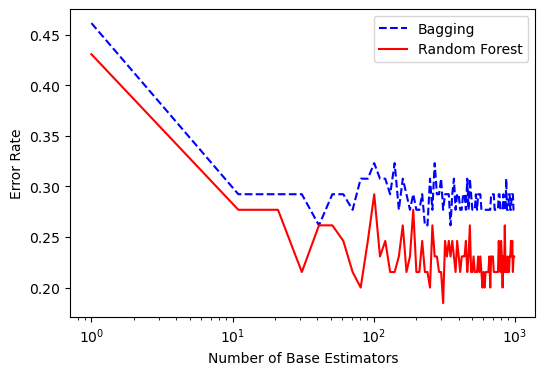

In [20]:
fig = plt.figure(figsize=(6,4))
plt.semilogx(num_of_estimators,bag_acc,label="Bagging",color="blue",ls="--")
plt.semilogx(num_of_estimators,rf_acc,label="Random Forest",color="red")
plt.xlabel("Number of Base Estimators")
plt.ylabel("Error Rate")
plt.legend()

Amazing😍,实验表明**随机森林在测试集上的误差要小于基础的Bagging**,说明随机森林有更优秀的**泛化能力**

我们一起来分析以下产生这个现象的原因

假设随机变量 $X_1,X_2,\cdots,X_B$ 独立同分布于 $N(\mu,\sigma^2)$, 则有:

$$
var\left(\frac{1}{B}\sum_{i=1}^{B}X_i \right) = \frac{1}{B}\sigma^2
$$

而如果放松部分假设,$X_1,\cdots,X_B$ **只是同分布**, **两两之间的相关系数**为 $\rho$, 则有:

$$
var\left( \frac{1}{B}\sum_{i=1}^{B}X_i \right) = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
$$

显然, 成立如下式子:

$$
\frac{1}{B}\sigma^2 < \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2, \quad B>1
$$

上式意味着, 方差 $\sigma^2/B$ 只是在独立同分布时的理论下界, **当变量间存在相关性时, 方差会偏大**

对于某个数据点 $x_0$, Bagging的预测结果为:

$$
f_{\text{bag}}(x_0) = \frac{1}{B}\sum_{b=1}^{B} \hat{f}(x_0;T^{(b)})
$$

因为Bagging在使用Bootstrap构造 $T^{(b)}$ 时会有重复样本,因此 $\hat{f}(x_0;T^{(b)})$ 之间会存在相关性, 假设为 $\rho$, 则:

$$
var(f_{\text{bag}}(x_0)) = \rho\sigma^2 + \frac{1 - \rho}{B}\sigma^2
$$

* 上式中, **第一项与** $B$ **无关**, 只与重复抽样的**数据集**有关
* **第二项可以通过增大** $B$ **逐渐减小**

因此,提升Bagging方法, **继续降低方差的另一种方法是减弱所构造基学习器之间的相关性**

而随机森林通过**构造决策树时使用随机采样样本和随机采样特征**的手段, 达到**降低不同基决策树之间相关性的目的**

从而, **随机森林比通常的Bagging效果更好**, 上述讨论与我们在本节一开始的实验结果完全吻合. 

最后，我们展示随机森林的**特征重要性**

Text(0, 0.5, 'Feature')

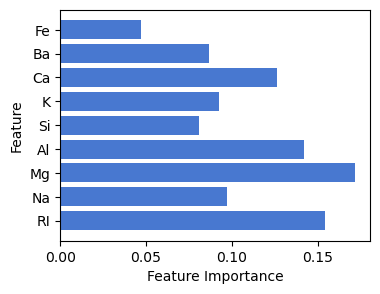

In [21]:
model = RandomForestClassifier()
model.fit(X,y)
FI = model.feature_importances_
fig = plt.figure(figsize=(4,3))
plt.barh(model.feature_names_in_,model.feature_importances_,color=colors[0])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

### **2.4 随机森林总结**

我们简单总结一下作为最强大的一类Bagging模型的**随机森林的优点**：
* **能够降低异常样本带来的影响**：由于对样本继续了随机采样建立多个基学习器，异常样本和极端样本在最终预测的贡献被降低了，Bagging模型通过参考多个基学习器的结果，能够很好地避免受到异常值的影响
* **降低泛化误差，减少过拟合**：上一节提到，使用决策树很大的一个问题是**模型非常容易过拟合**，现在随机森林借助**样本随机采样**和**特征随机采样**的技术，特征和数据在单个决策树上变少了，降低了过拟合的可能性，且相比一般的Bagging，特征随机化采样降低了基学习器预测之间的相关性，进一步降低模型方差
* **易于处理高维度数据**：决策树在面对高维度数据（$p$非常大）时，一方面容易出现过拟合，一方面每次特征分裂的搜索都需要大量的遍历，计算复杂度与 $\mathcal{O}(p)$ 成正比，现在随机森林每次只采样部分特征，计算复杂度大大降低，只需要增加基学习器数量 $B$，就能够获得很好的效果
* **具有Bagging类方法共同的优点：可并行、能进行包外估计**

----

## **练习**

1. 熟悉`sklearn`中`RandomForestClassifier()`和`RandomForestRegressor()`的方法参数，明白每个参数所起到的作用，理解每个参数在算法的哪个部分起作用

2. 使用随机森林对2.3节的`glass`数据集建模，将数据集切分为训练集和测试集，在训练时使用包外估计，对比包外估计的性能和模型在测试集上性能

----